👍**このnotebookが役に立った方は是非いいねをお願いします**👍  
👍**please upvote**👍

In [1]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
from xgboost import DMatrix
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, recall_score
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from tqdm import tqdm
# チャート用設定
# setting for chart
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

init_notebook_mode(connected=True)
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [2]:
test_day_count = 200
def ready_data():
    # データの読み込み
    # read csv and modify type of columns
    df = pd.read_csv("/kaggle/input/topix4/TOPIX4.csv", names=("Date", "Open", "High", "Low", "Close")).drop(0)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[(df['Date'].dt.year >= 2010)].copy()
    df.index = range(len(df))
    df["Open"] = df['Open'].astype(float)
    df["Close"] = df['Close'].astype(float)
    df["High"] = df['High'].astype(float)
    df["Low"] = df['Low'].astype(float)
    # 移動平均線と移動標準偏差
    # moving average and deviation of moving average
    df['EMA_9'] = df['Close'].ewm(9).mean().shift() / df['Close']
    df['SMA_5'] = df['Close'].rolling(5).mean().shift() / df['Close']
    df['SMA_10'] = df['Close'].rolling(10).mean().shift() / df['Close']
    df['SMA_15'] = df['Close'].rolling(15).mean().shift() / df['Close']
    df['SMA_30'] = df['Close'].rolling(30).mean().shift() / df['Close']
    df['EMA_9_std'] = df['Close'].ewm(9).std().shift() / df['Close']
    df['SMA_5_std'] = df['Close'].rolling(5).std().shift() / df['Close']
    df['SMA_10_std'] = df['Close'].rolling(10).std().shift() / df['Close']
    df['SMA_15_std'] = df['Close'].rolling(15).std().shift() / df['Close']
    df['SMA_30_std'] = df['Close'].rolling(30).std().shift() / df['Close']
    # 指数平滑移動平均
    # Exponential Moving Average
    # 指数平滑移動平均の日本語の説明↓
    # https://media-kojirokousi.com/exponential-moving-average/#:~:text=%E6%8C%87%E6%95%B0%E5%B9%B3%E6%BB%91%E7%A7%BB%E5%8B%95%E5%B9%B3%E5%9D%87%E7%B7%9A(EMA)%E3%81%AF%E3%80%81%E5%BE%93%E6%9D%A5%E3%81%AE,EMA%E3%81%A8%E5%91%BC%E3%81%B0%E3%82%8C%E3%81%BE%E3%81%99%E3%80%82
    EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
    EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
    # MACD
    # MACDの日本語の説明↓
    # https://www.sevendata.co.jp/shihyou/technical/macd.html
    df['MACD'] = pd.Series(EMA_12 - EMA_26)/ df['Close']
    df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())/ df['Close']
    df['RSI'] = relative_strength_idx(df).fillna(0)
    df["Change_label"] = change_rate(df)
    return df

def relative_strength_idx(df, n=14):
    close = df['Close']
    # 終値の前日との差分
    # diff from previous day
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    # 終値の上がりのみ、下がりのみでそれぞれカラムを作る
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    # 14日間の平均値上がりと、平均値下がり
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    #100-0に変換
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

def change_rate(df):
    #評価に終値の変化率を使うため
    #大きいプラス、小さいプラス、....大きいマイナスのような形でラベルで考えることもできる
    # qualtile([0.2, 0.4, 0.6, 0.8])で閾値を決定
    df['Change_rate'] = df['Close'].pct_change()
    df.loc[(df['Change_rate'] > -0.001714) & (df['Change_rate'] < 0.002856), 'Change_label'] = 0
    df.loc[(df['Change_rate'] > -0.001714) & (df['Change_rate'] < 0.002856), 'weight'] = 1
    df.loc[(df['Change_rate'] >= -0.008004) & (df['Change_rate'] <= -0.001714), 'Change_label'] = -1
    df.loc[(df['Change_rate'] >= -0.008004) & (df['Change_rate'] <= -0.001714), 'weight'] = 1.2
    df.loc[df['Change_rate'] < -0.008004, 'Change_label'] = -2
    df.loc[df['Change_rate'] < -0.008004, 'weight'] = 1.5
    df.loc[(df['Change_rate'] <= 0.008758) & (df['Change_rate'] >= 0.002856), 'Change_label'] = 1
    df.loc[(df['Change_rate'] <= 0.008758) & (df['Change_rate'] >= 0.002856), 'weight'] = 1.2
    df.loc[df['Change_rate'] > 0.008758, 'Change_label'] = 2
    df.loc[df['Change_rate'] > 0.008758, 'weight'] = 1.5
    return df['Change_label']

df = ready_data()
df.tail(100)

Date     Open     High      Low    Close     EMA_9     SMA_5  \
2496 2020-03-16  1268.39  1288.47  1231.67  1236.34  1.206218  1.095225   
2497 2020-03-17  1216.92  1280.63  1199.25  1268.46  1.155574  1.043426   
2498 2020-03-18  1279.27  1313.83  1269.38  1270.84  1.137882  1.019719   
2499 2020-03-19  1289.80  1313.07  1272.98  1283.22  1.113249  0.992070   
2500 2020-03-23  1278.86  1296.98  1261.62  1292.01  1.094427  0.978407   
...         ...      ...      ...      ...      ...       ...       ...   
2591 2020-08-05  1548.57  1555.75  1540.17  1554.71  1.000136  0.985711   
2592 2020-08-06  1552.88  1559.44  1545.56  1549.88  1.003239  0.989514   
2593 2020-08-07  1549.96  1553.41  1540.23  1546.74  1.004951  0.992869   
2594 2020-08-11  1561.16  1586.02  1560.17  1585.96  0.979617  0.974707   
2595 2020-08-12  1588.80  1607.92  1586.21  1605.53  0.969689  0.970714   

        SMA_10    SMA_15    SMA_30  ...  SMA_5_std  SMA_10_std  SMA_15_std  \
2496  1.155913  1.200768  1.286317  ...   0.048138    0.072416    0.091488   
2497  1.103817  1.147360  1.242224  ...   0.058667    0.079513    0.092340   
2498  1.083128  1.126861  1.228986  ...   0.047300    0.079676    0.092227   
2499  1.054625  1.098569  1.206692  ...   0.026164    0.074470    0.088487   
2500  1.029456  1.076397  1.188136  ...   0.013441    0.060683    0.084284   
...        ...       ...       ...  ...        ...         ...         ...   
2591  0.999608  1.004329  1.004427  ...   0.015307    0.017986    0.016286   
2592  1.001283  1.006671  1.007033  ...   0.016061    0.017289    0.016236   
2593  1.001192  1.008057  1.008274  ...   0.016756    0.015843    0.016330   
2594  0.974779  0.981330  0.982630  ...   0.008476    0.014478    0.015116   
2595  0.963475  0.969655  0.971153  ...   0.009806    0.015246    0.015260   

      SMA_30_std      MACD   MACD_signal        RSI  Change_rate  \
2496    0.108565 -0.083152 -4.576907e-05   9.692671    -0.020100   
2497    0.116586 -0.083628 -4.887381e-05  15.804289     0.025980   
2498    0.123213 -0.084389 -5.230663e-05  17.556652     0.001876   
2499    0.127646 -0.082565 -5.430997e-05  22.456140     0.009742   
2500    0.130515 -0.079740 -5.549593e-05  21.273094     0.006850   
...          ...       ...           ...        ...          ...   
2591    0.013487 -0.003652 -9.863502e-07  47.426036    -0.000354   
2592    0.013380 -0.003431 -1.234268e-06  39.188083    -0.003107   
2593    0.013069 -0.003378 -1.426247e-06  40.816095    -0.002026   
2594    0.012576 -0.001239 -1.269024e-06  52.883745     0.025357   
2595    0.012808  0.001353 -8.342465e-07  56.295282     0.012340   

      Change_label  weight  
2496          -2.0     1.5  
2497           2.0     1.5  
2498           0.0     1.0  
2499           2.0     1.5  
2500           1.0     1.2  
...            ...     ...  
2591           0.0     1.0  
2592          -1.0     1.2  
2593          -1.0     1.2  
2594           2.0     1.5  
2595           2.0     1.5  

[100 rows x 21 columns]

In [3]:
# 始値、高値、安値、終値のグラフ
# graph of Open, High, Low, Close
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Ohlc(x=df.Date,
                      open=df.Open,
                      high=df.High,
                      low=df.Low,
                      close=df.Close,
                      name='Price'), row=1, col=1)
fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

In [4]:
# emaとsmaのグラフ
# graph of EMA and SMA
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close', opacity=0.2))
fig.show()

In [5]:
# graph of MACD
# MACDのグラフ
EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

In [6]:
fig = go.Figure(go.Scatter(x=df.Date, y=df.RSI, name='RSI'))
fig.show()

In [7]:
def modify_and_split_data_for_xgb(df):
    # ↓前日のデータを特徴量に入れたが特に重要なパラメータではなかったため、削除
    # df['today_change_rate_label'] = df['Change_label']
    
    # 前日のデータから、翌日の終値を予測するため、closeをshiftしている。
    # ↓we would like to predict tommorow's movement
    df['Change_label'] = df['Change_label'].shift(-1)
    df['weight'] = df['weight'].shift(-1)
    df['Change_rate'] = df['Change_rate'].shift(-1)

    df = df.iloc[33:] # Because of moving averages and MACD line
    df = df[:-1]      # Because of shifting close price
    df["Change_label"] = df["Change_label"].astype('int')
    df = df.reset_index()
    df = df.drop(['index'], 1)
    test_df   = df.loc[len(df) - test_day_count:].copy()
    train_df   = df.loc[: len(df) - test_day_count - 1].copy()

#     テスト期間を設けずに、Change_labelの割合が均等になるように分割する
#     train_df, valid_df = train_test_split(train_df, test_size=0.19, stratify=train_df.Change_label)
    train_df, valid_df = train_test_split(train_df, test_size=0.19, stratify=train_df.Change_label, random_state=7843242)
    return df, train_df, valid_df, test_df
df, train_df, valid_df, test_df = modify_and_split_data_for_xgb(df)

In [8]:
def get_label_and_explanatory_variable(df):
    drop_cols = ['Date', 'Open', 'Low', 'High', 'Close', 'Change_rate']
    df = df.drop(drop_cols, 1)
    # closeの値を予測することにする。
    label = df['Change_label'].copy()
    explanatory = df.drop(['Change_label'], 1)
    return explanatory, label
X_train, y_train = get_label_and_explanatory_variable(train_df)
X_valid, y_valid = get_label_and_explanatory_variable(valid_df)
X_test, y_test = get_label_and_explanatory_variable(test_df)
eval_set = [(X_train, y_train), (X_valid, y_valid)]

In [9]:
weights = X_train["weight"].astype('float')
X_train = X_train.drop("weight", axis=1)
X_valid = X_valid.drop("weight", axis=1)
X_test = X_test.drop("weight", axis=1)
eval_set = [(X_train, y_train), (X_valid, y_valid)]

In [10]:
%%time
# # grid Searchは時間がかかるので、コメントで使ったり使わなかったりを切り替える
# # grid search needs not a little time, switch it by comment-out
# parameters = {
#     'n_estimators': [100, 200, 300, 400],
#     'learning_rate': [0.001, 0.005, 0.01, 0.05],
#     'max_depth': [8, 10, 12, 15],
#     'gamma': [0.001, 0.005, 0.01, 0.02],
#     'random_state': [42],
#     'num_class' : [5]
# }

# eval_set = [(X_train, y_train), (X_valid, y_valid)]
# model = xgb.XGBClassifier(objective='multi:softprob')
# clf = GridSearchCV(model, parameters)

# clf.fit(X_train, y_train)

# print(f'Best params: {clf.best_params_}')
# # 'gamma': 0.005, 'learning_rate': 0.005, 'max_depth': 10, 'n_estimators': 300, 'num_class': 5, 'random_state': 42}
# print(f'Best validation score = {clf.best_score_}')

# model = xgb.XGBClassifier(**clf.best_params_, objective='multi:softprob')
## {'gamma': 0.02, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200, 'num_class': 5, 'random_state': 42}
model = xgb.XGBClassifier(n_estimators=200, 
    learning_rate=0.05,
    max_depth= 8,
    gamma=0.02,
    random_state= 42,
    num_class =5,
    objective='multi:softprob')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False, sample_weight = weights)

CPU times: user 12.9 s, sys: 73.3 ms, total: 12.9 s
Wall time: 3.32 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.02, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_class=5, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

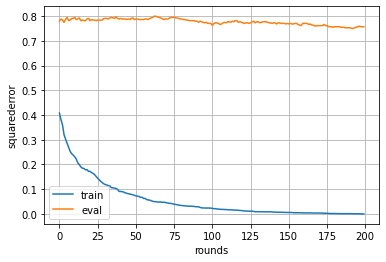

In [11]:
evals_result = model.evals_result()
train_metric = evals_result['validation_0']['merror']
plt.plot(train_metric, label='train')
eval_metric = evals_result['validation_1']['merror']
plt.plot(eval_metric, label='eval')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('squarederror')
plt.show()

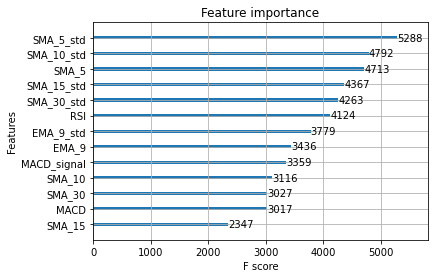

In [12]:
plot_importance(model);

In [13]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

y_true = [ 2  1 -1  0  1]
y_pred = [ 1  0 -1 -1 -1]
mean_squared_error = 3.995


In [14]:
predicted_prices = df.loc[len(df)-test_day_count:].copy()
predicted_prices['Change_label'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Change_label,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Change_label,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()

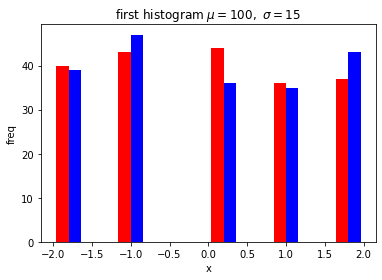

In [15]:
# 真の分布と予測結果の分布
# graph of test_data and predicted_data
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.hist([y_pred, y_test], bins=10, color=['red', 'blue'], label=['y_pred', 'y_test'])
ax.set_title('first histogram $\mu=100,\ \sigma=15$')
ax.set_xlabel('x')
ax.set_ylabel('freq')
fig.show()

In [16]:
acc = accuracy_score(y_test, y_pred)
print(acc)

0.25


In [17]:
confusion_matrix(y_test, y_pred)

array([[13,  5,  3,  8, 10],
       [ 6, 10, 11,  9, 11],
       [ 7, 11,  9,  7,  2],
       [ 5, 12, 10,  6,  2],
       [ 9,  5, 11,  6, 12]])

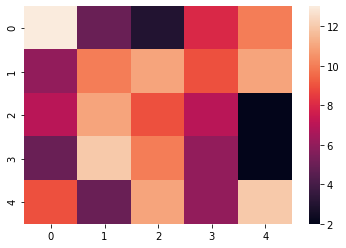

In [18]:
sns.heatmap(confusion_matrix(y_test, y_pred))

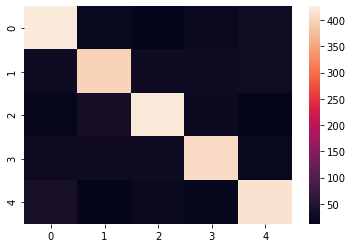

In [19]:
datas = df.copy()
drop_cols = ['Date', 'Open', 'Low', 'High', 'Close', 'Change_rate', 'Change_label', 'weight']
datas = datas.drop(drop_cols, 1)
all_pred = model.predict(datas)
sns.heatmap(confusion_matrix(df.Change_label, all_pred))

In [20]:
acc_his = pd.DataFrame(columns = ['Acc', 'Date', 'Change_rate'])
for i in range(0, len(df), 30):
    datas = df.loc[i:i+30].copy()
    ans = datas['Change_label']
    rate = df.loc[i:i+30, 'Change_rate'].mean()
    drop_cols = ['Date', 'Open', 'Low', 'High', 'Close', 'Change_rate', 'Change_label', 'weight']
    datas = datas.drop(drop_cols, 1)
    pred = model.predict(datas)
    acc_his.loc[df.loc[i].Date] = [accuracy_score(ans, pred), df.loc[i].Date, rate]

                  Acc  Change_rate
Acc          1.000000     0.012254
Change_rate  0.012254     1.000000


Text(0, 0.5, 'Change_rate')

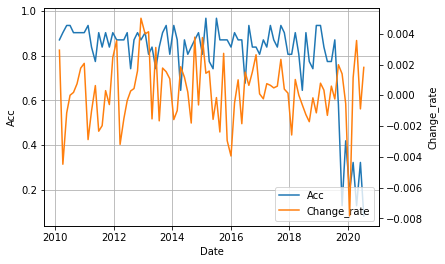

In [21]:
print(acc_his.corr())
fig = plt.figure()
ax1 = fig.add_subplot(111)
t = acc_his.Date
fs = 1.0
y1 = acc_his.Acc
ln1=ax1.plot(t, y1,'C0',label='Acc')

ax2 = ax1.twinx()
y2 = acc_his.Change_rate
ln2=ax2.plot(t,y2,'C1',label='Change_rate')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='lower right')

ax1.set_xlabel('Date')
ax1.set_ylabel('Acc')
ax1.grid(True)
ax2.set_ylabel('Change_rate')

## リターン計測について/return 

W_0 = 1

W_{t+1} =  ( 1 + r_{t+1} * w_t ) W_t

### 記号

* W_t : 時刻tでの保有資産額
* r_t : 時刻{t-1} から 時刻tまでのTOPIX変化率
* w_t : 自分の投資比率

### 予測と投資比率の関係
5値分類問題として予測を行った場合
予測は、時点tで時点t+1の予測を行った場合を想定

* +2 : 大幅なTOPIX上昇  => w_t =  1.0 
* +1 : 小幅なTOPIX上昇  => w_t =  0.5
*  0 : TOPIX変化なし  　=> w_t =  0.0
* -1 : 小幅なTOPIX下落  => w_t = -0.5
* -2 : 大幅なTOPIX下落  => w_t = -1.0

In [22]:
for_dump = df.copy()
def simulate_based_on_predict(df):
    money_his = pd.DataFrame(columns = ['Date', 'money'])
    df = df.copy().reset_index()
    df = df.drop(['index'], 1)
    drop_cols = ['Date', 'Open', 'Low', 'High', 'Close', 'Change_rate', 'Change_label', 'weight']
    datas = df.copy().drop(drop_cols, 1)
    pred = model.predict(datas)
    money = 1
    for i in range(0, len(df)):
        data = df.loc[i].copy()
        today_pred = pred[i]
#         dfに入っているChange_rateは次の日の変化率なので、これを使って良い
        Change_rate = data.Change_rate
        if (today_pred == -2):
            money = (1 + Change_rate * -1) * money
        elif (today_pred == -1):
            money = (1 + Change_rate * -0.5) * money
        elif (today_pred == 1):
            money = (1 + Change_rate * 0.5) * money
        elif (today_pred == 2):
            money = (1 + Change_rate * 1) * money
        money_his.loc[data.Date] = [data.Date, money]
        for_dump.loc[i, "pred"] = pred[i]
    return money, money_his
money, money_his = simulate_based_on_predict(df.copy())
print(money)
recent_money, recent_money_his = simulate_based_on_predict(df.loc[len(df) - test_day_count:].copy())
print(recent_money)
fig = go.Figure(go.Scatter(x=money_his.Date, y=money_his.money, name='money_history'))
fig.show()
fig = go.Figure(go.Scatter(x=recent_money_his.Date, y=recent_money_his.money, name='money_history'))
fig.show()

1409577.413464841
0.9259455961928458


In [23]:
df.to_csv("for_dump.csv")
money_his.to_csv("money_his.csv")
recent_money_his.to_csv("recent_money_his.csv")